In [1]:
import os
import pandas as pd
from general_analysis_functions import (load_suppliers,
                                        load_payments,
                                        scoring_figures,
                                        summarize_suppliers,
                                        plot_match_distribution)
%load_ext autoreload
%autoreload 2

data_path = os.path.abspath(os.path.join(os.getcwd(), '../..', 'data'))
merge_path = os.path.join(data_path, 'data_nhsccgs', 'merge')
recon_path = os.path.join(data_path, 'data_nhsccgs', 'reconciled')
figure_path = os.path.abspath(os.path.join(
                              os.path.join(os.getcwd(),
                                           '../..', 'papers', 'figures')))
sup_df = load_suppliers(os.path.join(recon_path, 'recon_verified.tsv'))
pay_df = load_payments(os.path.join(merge_path, 'merged_with_recon.tsv'))

In [2]:
summarize_suppliers(sup_df, pay_df)

Length of supplier dataset: 10951
Total unique suppliers in supplier dataset: 10951
Total unique normalized suppliers in supplier dataset: 10701
Total unique verified suppliers in supplier dataset: 4290
Total verified suppliers dataset: 5823
Total unverified suppliers in the suppliers dataset: 5128


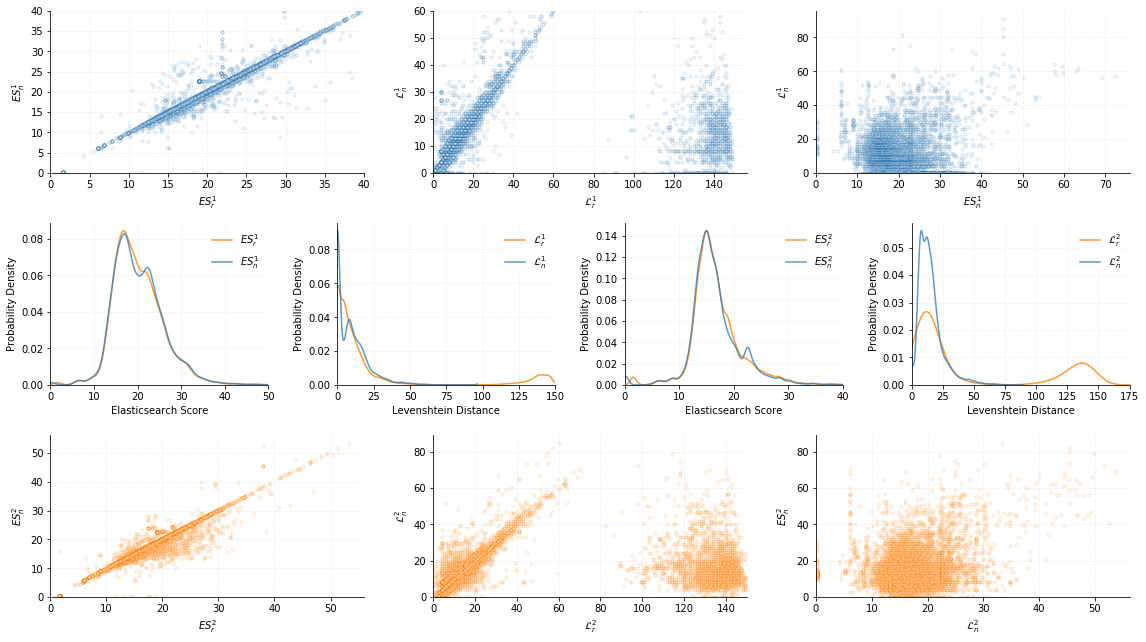

In [3]:
scoring_figures(sup_df, figure_path, (16, 9))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


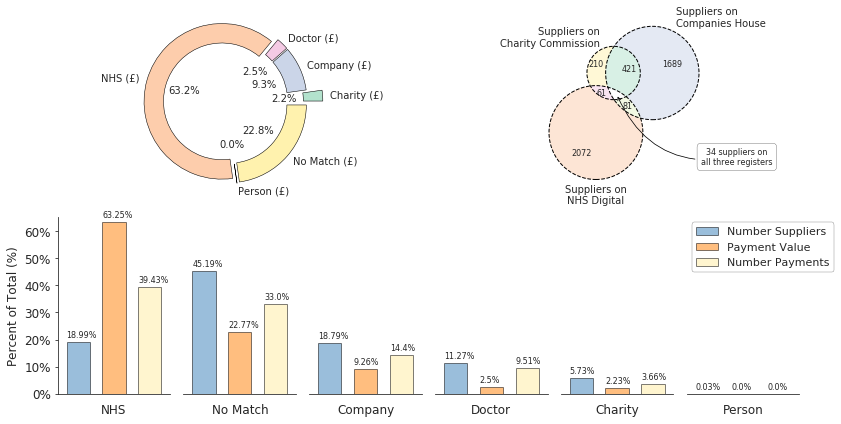

In [61]:
from general_analysis_functions import (load_suppliers,
                                        load_payments,
                                        scoring_figures,
                                        summarize_suppliers,
                                        plot_match_distribution)
%load_ext autoreload
%autoreload 2
plot_match_distribution(sup_df, pay_df, figure_path, (12, 6))